# Análise Generalizada de SAM (Spectral Angle Mapper)

Este notebook permite configurar parâmetros operacionais (RPM, Diâmetro de Falha) e realizar automaticamente:
1.  **Busca de Sinais Reais**: Seleção robusta de múltiplos sinais de referência no dataset.
2.  **Geração de Sinais Sintéticos**: Criação de sinais via métodos FFT e Impulso para as condições especificadas.
3.  **Comparação Quantitativa**: Cálculo da métrica SAM par-a-par e estatística (Média/Desvio).

In [16]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import cosine
import random

# Adicionar src ao path para importar módulos do projeto
sys.path.append(os.path.abspath('src'))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

## 1. Configuração de Parâmetros
Defina aqui as condições operacionais para a análise.

In [17]:
# --- Parâmetros de Entrada ---
TARGET_RPM = 1750          # Rotação do eixo (Ex: 1730, 1750, 1772, 1797)
TARGET_DIAMETER_MM = 0.5   # Diâmetro da falha alvo em mm (aprox 0.021")
NUM_SAMPLES = 20            # Número de amostras reais para usar na média do SAM

# --- Constantes do Sistema ---
FS = 12000                 # Frequência de Amostragem (Hz)
N_POINTS = 4096            # Tamanho do segmento

In [18]:
# --- Configuração de Sweep de Parâmetros ---

# RPMs disponíveis no dataset CWRU
RPMS = [1730, 1750, 1772, 1797]

# Diâmetros de falha em mm (aproximadamente 0.007", 0.014", 0.021", 0.028")
DIAMETERS_MM = [0.1778, 0.3556, 0.5334, 0.7112]

# Labels convenientes para visualização
CWru_DIA_MAP = {
    0.1778: '0.007"',
    0.3556: '0.014"',
    0.5334: '0.021"',
    0.7112: '0.028"'
}

# Grade de K por tipo de falha (valores centrados nos usados na Seção 3)
K_GRID = {
    'OR': [0.02, 0.05, 0.1],   # Outer race (Pista Externa)
    'IR': [0.5, 0.8, 1],      # Inner race (Pista Interna)
    'B':  [0.02, 0.05, 0.08]       # Ball (Esfera)
}


## 2. Funções Auxiliares
Funções para cálculo do SAM, espectro e filtragem de dados.

In [19]:
from general_sam_analysis_utils import (
    calcular_sam_graus,
    get_mag_spectrum,
    get_real_signals_metadata_batch,
    get_normal_signal,
    pad_or_trim,
)

# Obs.: a geração do sinal por impulso agora vem de `generate_impulse_data.py` (importado como `gid`).

## 3. Execução da Análise
Geração e Comparação para todas as falhas.

In [20]:
# 3. Execução da Análise em Sweep (RPM × Diâmetro × K)

results = []

falhas = [
    ('Pista Externa', 'OR', 'outer'),
    ('Pista Interna', 'IR', 'inner'),
    ('Esfera',       'B',  'ball')
]

print("Iniciando sweep de parâmetros para SAM...\n")

for rpm in RPMS:
    # Ruído de fundo (Normal) para este RPM
    sinal_normal = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)

    for diam_mm in DIAMETERS_MM:
        for nome, type_code, gen_type in falhas:
            # Grade de K dependente do tipo de falha
            for k_val in K_GRID[type_code]:
                # 1. Obter Sinais Reais de Referência
                refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                num_refs = len(refs)

                # 2. Calcular Frequência de Falha (para Impulso)
                tandon_coeffs = bu.calculate_tandon_coefficients(diam_mm, rpm, gen_type)
                char_freq = tandon_coeffs['frequencies']['defect_freq_hz']

                # --- Método A: Tandon (FFT -> Tempo) via src/generate_synthetic_data.py ---
                try:
                    sig_fft_pure, sig_fft_final = gsd.gerar_sinal_tandon_completo(
                        fs=FS,
                        n_points=N_POINTS,
                        diametro_mm=diam_mm,
                        rpm=rpm,
                        tipo_falha=nome,  # 'Pista Externa'|'Pista Interna'|'Esfera'
                        k_val=k_val,
                        sinal_normal=sinal_normal,
                    )
                except Exception as e:
                    print(f"[Erro Tandon FFT Gen] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                    sig_fft_final = np.zeros(N_POINTS)
                    sig_fft_pure = np.zeros(N_POINTS)

                # --- Método B: Impulse Model (via src/generate_impulse_data.py) ---
                try:
                    sig_imp_pure = gid.gerar_sinal_impulso_completo(
                        fs=FS,
                        duration_points=N_POINTS,
                        defect_freq_hz=char_freq,
                        tipo_falha_str=nome,
                    )
                    # Escala pela mesma K para tornar comparável
                    sig_imp_final = sinal_normal + (k_val * sig_imp_pure)
                except Exception as e:
                    print(f"[Erro Impulso] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                    sig_imp_final = np.zeros(N_POINTS)

                # 3. Calcular SAM e registrar resultados
                sam_fft_vals = []
                sam_imp_vals = []

                spec_syn_fft = get_mag_spectrum(sig_fft_final)
                spec_syn_imp = get_mag_spectrum(sig_imp_final)

                for _, sig_real in refs:
                    spec_real = get_mag_spectrum(sig_real)
                    sam_fft_vals.append(calcular_sam_graus(spec_real, spec_syn_fft))
                    sam_imp_vals.append(calcular_sam_graus(spec_real, spec_syn_imp))

                # Se não houver referências, usar NaN
                if sam_fft_vals:
                    mean_fft = float(np.mean(sam_fft_vals))
                    std_fft = float(np.std(sam_fft_vals))
                else:
                    mean_fft, std_fft = np.nan, np.nan

                if sam_imp_vals:
                    mean_imp = float(np.mean(sam_imp_vals))
                    std_imp = float(np.std(sam_imp_vals))
                else:
                    mean_imp, std_imp = np.nan, np.nan

                dia_label = CWru_DIA_MAP.get(min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm)), f"{diam_mm:.4f}m")

                results.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'method': 'fft',
                    'k': k_val,
                    'num_refs': num_refs,
                    'sam_mean_deg': mean_fft,
                    'sam_std_deg': std_fft
                })

                results.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'method': 'impulse',
                    'k': k_val,
                    'num_refs': num_refs,
                    'sam_mean_deg': mean_imp,
                    'sam_std_deg': std_imp
                })

# Consolidar em DataFrame
results_df = pd.DataFrame(results)
print("Sweep concluído. Total de linhas em results_df:", len(results_df))
results_df.head()

Iniciando sweep de parâmetros para SAM...

[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=OR, K=0.02: module 'generate_synthetic_data' has no attribute 'gerar_sinal_tandon_completo'
[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=OR, K=0.05: module 'generate_synthetic_data' has no attribute 'gerar_sinal_tandon_completo'
[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=OR, K=0.1: module 'generate_synthetic_data' has no attribute 'gerar_sinal_tandon_completo'
[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=IR, K=0.5: module 'generate_synthetic_data' has no attribute 'gerar_sinal_tandon_completo'
[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=IR, K=0.8: module 'generate_synthetic_data' has no attribute 'gerar_sinal_tandon_completo'
[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=IR, K=1: module 'generate_synthetic_data' has no attribute 'gerar_sinal_tandon_completo'
[Erro Tandon FFT Gen] RPM=1730, dia=0.1778, tipo=B, K=0.02: module 'generate_synthetic_data' has no attribute 'gerar_

,rpm,diameter_mm,diameter_label,fault_name,fault_code,method,k,num_refs,sam_mean_deg,sam_std_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.02,20,NaN,NaN
1,1730,0.1778,"0.007""",Pista Externa,OR,impulse,0.02,20,82.444699,3.422031
2,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.05,20,NaN,NaN
3,1730,0.1778,"0.007""",Pista Externa,OR,impulse,0.05,20,81.849901,3.379315
4,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.10,20,NaN,NaN


## 4. Visualização Agregada dos Resultados

A partir de `results_df`, podemos criar visualizações agregadas para entender o efeito de RPM, diâmetro, K e tipo de falha sobre o SAM médio.


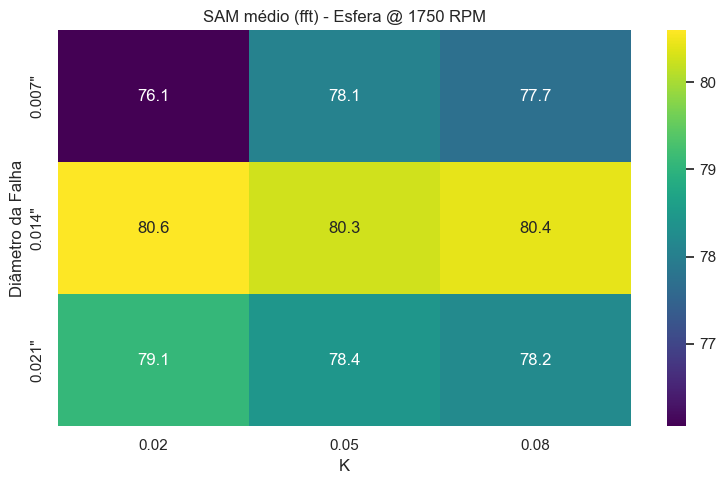

Top 10 combinações (maior SAM médio):


,rpm,fault_name,method,diameter_label,k,num_refs,sam_mean_deg,sam_std_deg
40,1730,Pista Externa,fft,"0.021""",0.10,20,85.880875,0.867972
184,1772,Pista Externa,fft,"0.021""",0.10,20,85.577035,1.142053
112,1750,Pista Externa,fft,"0.021""",0.10,20,85.490903,1.399419
76,1750,Pista Externa,fft,"0.007""",0.10,20,85.415689,2.584267
256,1797,Pista Externa,fft,"0.021""",0.10,20,85.330922,1.440095
220,1797,Pista Externa,fft,"0.007""",0.10,20,84.956706,2.331786
148,1772,Pista Externa,fft,"0.007""",0.10,20,84.907880,2.519890
166,1772,Pista Externa,fft,"0.014""",0.10,20,84.893912,1.538124
38,1730,Pista Externa,fft,"0.021""",0.05,20,84.727237,0.821156
37,1730,Pista Externa,impulse,"0.021""",0.02,20,84.634048,0.316451


In [8]:
import seaborn as sns

# Garantir estilo
sns.set(style="whitegrid")

# Exemplo: heatmap para um RPM específico e um tipo de falha
rpm_plot = 1750
fault_plot = 'Esfera'
method_plot = 'fft'  # ou 'impulse'

subset = results_df[(results_df['rpm'] == rpm_plot) &
                    (results_df['fault_name'] == fault_plot) &
                    (results_df['method'] == method_plot)]

if subset.empty:
    print(f"Nenhum dado em results_df para RPM={rpm_plot}, falha='{fault_plot}', método='{method_plot}'.")
else:
    pivot = subset.pivot_table(index='diameter_label', columns='k', values='sam_mean_deg', aggfunc='mean')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='viridis')
    plt.title(f'SAM médio ({method_plot}) - {fault_plot} @ {rpm_plot} RPM')
    plt.xlabel('K')
    plt.ylabel('Diâmetro da Falha')
    plt.tight_layout()
    plt.show()

# Tabela: top 10 combinações mais similares (menor SAM) para cada método
rank_df = (results_df
           .dropna(subset=['sam_mean_deg'])
           .sort_values('sam_mean_deg', ascending=False)
           .head(10))

print("Top 10 combinações (maior SAM médio):")
rank_df[['rpm', 'fault_name', 'method', 'diameter_label', 'k', 'num_refs', 'sam_mean_deg', 'sam_std_deg']]
